# Magnetosphere region classification

In [1]:
import sys
sys.path.insert(0,"..")
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import speasy as spz
import sklearn
import os
import pickle as pkl

# locally defined functions
import speasy_utils.amda as amda_utils
#import amda_utils

# default format for datetime objects
date_fmt="%Y-%m-%dT%H:%M:%S"
# excess time for interpolation
delta_t = timedelta(days=1)
# ACE data timeshift
shift_t = timedelta(seconds=4000)

## Start and stop times
We want at least a year's worth of data.

In [2]:
#start, stop = "2007-03-01T00:00:00", "2008-03-01T00:00:00"
start, stop = "2007-03-01T00:00:00", "2009-04-01T00:00:00"
start, stop = datetime.strptime(start, date_fmt), \
    datetime.strptime(stop, date_fmt)
# used for naming data file
start_str, stop_str = start.strftime(date_fmt),stop.strftime(date_fmt)
# start and stop for getting data
start_d, stop_d = start - delta_t, stop + delta_t

In [3]:
parameter_ids = ["thb_n_i","thb_bs","imf","sw_n","thb_xyz",
                "tha_n_i","tha_bs","tha_xyz"]
m = len(parameter_ids)
parameter_shifts = {"imf":shift_t, "sw_n":shift_t}

In [4]:
data_filename = f"parameter_data_{start_str}_{stop_str}.pkl"

parameter_data = amda_utils.get_parameter_data(parameter_ids, 
                                    start_d,
                                    stop_d,
                                    data_filename, 
                                    shifts=parameter_shifts)

Check out the data. 

In [5]:
print("ID shape nans")
for k in parameter_data:
    print(k, parameter_data[k].data.shape,\
          np.isnan(parameter_data[k].data).sum())

ID shape nans
thb_n_i (201107, 1) 27066
thb_bs (21394464, 3) 0
imf (4125595, 3) 3393
sw_n (1031402, 1) 369799
thb_xyz (1100160, 3) 0
tha_n_i (361094, 1) 41332
tha_bs (21514110, 3) 0
tha_xyz (1100160, 3) 0


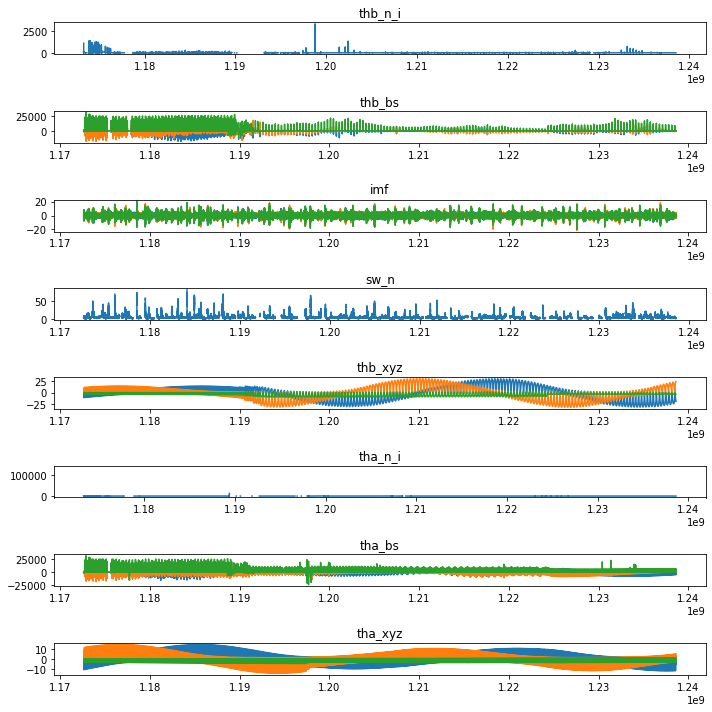

In [6]:
f, axes = plt.subplots(len(parameter_ids), 1, figsize=(10,10))
for (k,p),ax in zip(parameter_data.items(),axes):
    ax.plot(p.time, p.data)
    ax.set_title(k)
plt.tight_layout()
plt.show()

In [7]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]
def clean_data(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

for k in parameter_data:
    if np.any(np.isnan(parameter_data[k].data)):
        new_data = clean_data(parameter_data[k].data)
        parameter_data[k].data = new_data


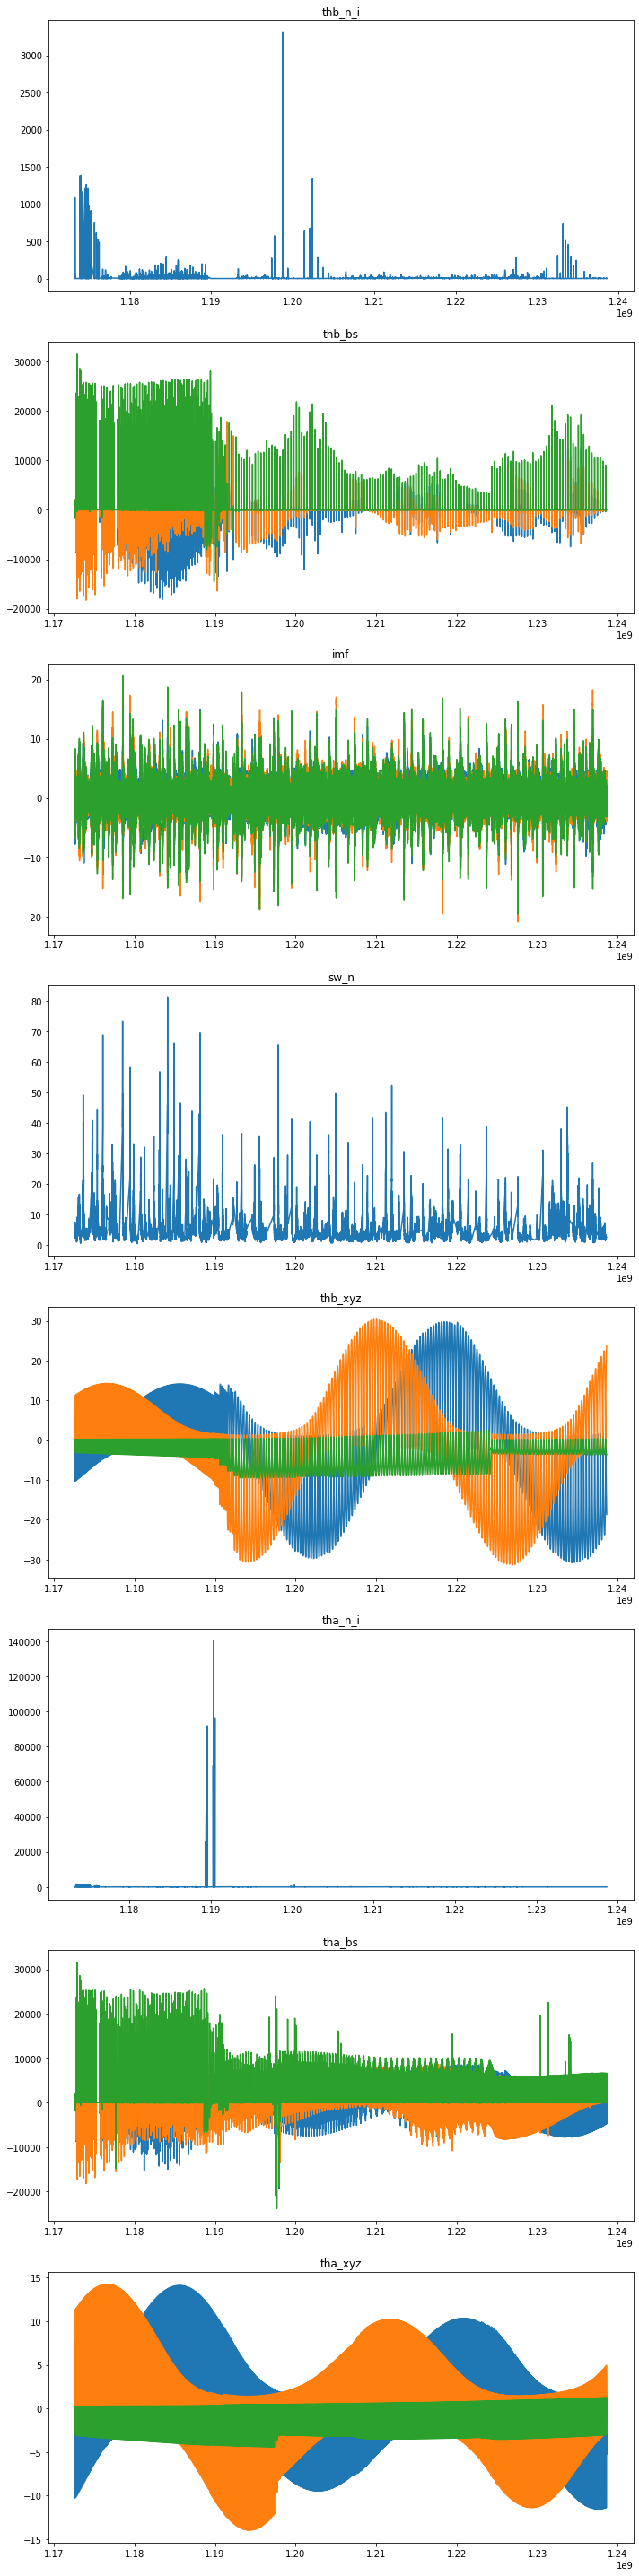

In [8]:
f, axes = plt.subplots(len(parameter_ids), 1, figsize=(10,m*5))
for (k,p),ax in zip(parameter_data.items(),axes):
    ax.plot(p.time, p.data)
    ax.set_title(k)
plt.tight_layout()
plt.show()

In [9]:
from scipy.interpolate import interp1d

interp_data = {}

for k in parameter_data:
    interp_data[k] = interp1d(parameter_data[k].time, parameter_data[k].data, axis=0)


In [10]:
bounds = [None, None]
for k in parameter_data:
    t = parameter_data[k].time
    if bounds[0] is None or np.min(t)>bounds[0]:
        bounds[0] = np.min(t)
    if bounds[1] is None or np.max(t)<bounds[1]:
        bounds[1] = np.max(t)
bounds = [datetime.fromtimestamp(e) for e in bounds]
print(f"Interpolation bounds : {bounds}")

Interpolation bounds : [datetime.datetime(2007, 3, 7, 19, 54, 2, 171000), datetime.datetime(2009, 3, 31, 18, 20, 17, 648000)]


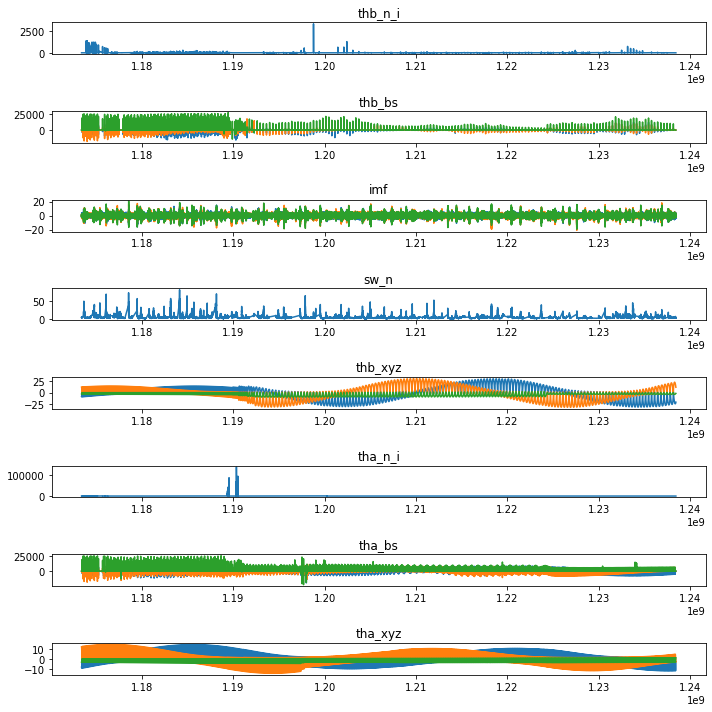

In [11]:
t = pd.date_range(bounds[0]+delta_t,bounds[1]-delta_t,freq="60S").astype(np.int64)/1e9
interpolated_data = {}
for k in parameter_data:
    interpolated_data[k]=interp_data[k](t)

f, axes = plt.subplots(len(parameter_ids), 1, figsize=(10,10))
for (k,p),ax in zip(parameter_data.items(),axes):
    ax.plot(t, interpolated_data[k])
    ax.set_title(k)
plt.tight_layout()
plt.show()


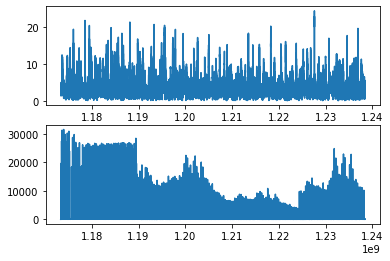

In [12]:
B_ace = np.linalg.norm(interpolated_data["imf"], axis=1)

plt.subplot(2,1,1)
plt.plot(t, B_ace)

plt.subplot(2,1,2)
B_tha = np.linalg.norm(interpolated_data["thb_bs"], axis=1)
plt.plot(t, B_tha)


In [13]:
n_ace = interpolated_data["sw_n"]
n_tha = interpolated_data["thb_n_i"]

(1084227, 1)
0


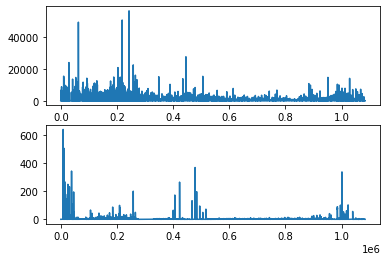

In [14]:
r_b = B_tha / B_ace
r_n = (n_tha / n_ace).flatten()
print(n_tha.shape)
print(np.sum(n_tha < 0.))

f, axes = plt.subplots(2,1)
axes[0].plot(r_b)
axes[1].plot(r_n)
plt.show()

0 0
0 0
0 0
2.5740328363148866e-06 638.5798687443747 0.010281146991352031 56803.56338887983


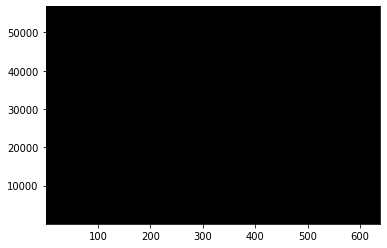

In [15]:
print(np.sum(np.isnan(r_b)), np.sum(np.isnan(r_n)))
cmap="gist_stern"
esp= 1.e-1
#plt.hist2d(r_n, r_b, bins=1000, range=domain,cmap=cmap)
print(np.sum(np.isnan(r_n)), np.sum(np.isnan(r_b)))
print(np.sum(np.isinf(r_n)), np.sum(np.isinf(r_b)))
print(r_n.min(),r_n.max(), r_b.min(), r_b.max())
plt.hist2d(r_n, r_b, bins=1000, range=None,cmap=cmap)
plt.show()

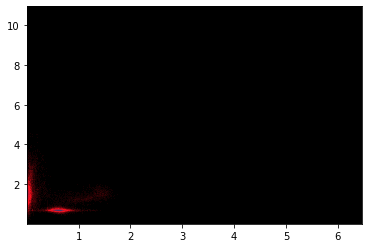

In [16]:
esp= 1.e-1
#domain = np.array([[0,8],[0,30]])
#domain_ = np.log(1+domain)
#hist_data = plt.hist2d(np.log(1+r_n), np.log(1+r_b), bins=1000, range=domain_,cmap=cmap)
hist_data = plt.hist2d(np.log(1+r_n), np.log(1+r_b), bins=1000, range=None,cmap=cmap)
plt.show()

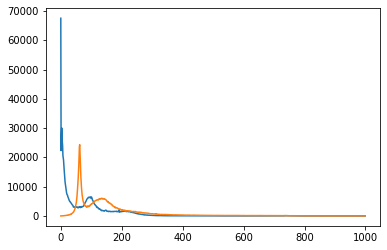

In [17]:
plt.plot(hist_data[0].sum(axis=1))
plt.plot(hist_data[0].sum(axis=0))
plt.show()

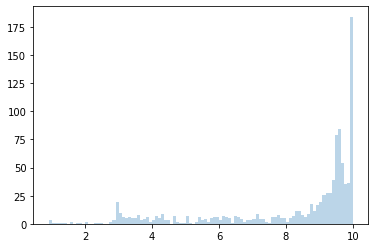

In [18]:
a,b=hist_data[0].sum(axis=0),hist_data[0].sum(axis=1)
plt.hist(1./(1.e-1+a/a.max()),alpha=.3,bins=100)
#plt.hist(1./(1+np.exp(-b/b.max())),alpha=.3,bins=100)
plt.show()

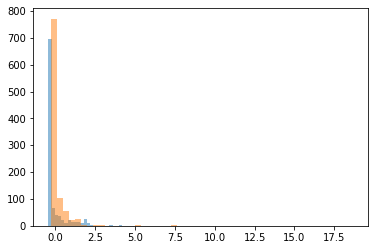

In [19]:
aa=(a-np.mean(a))/np.std(a)
bb=(b-np.mean(b))/np.std(b)
plt.hist(aa,alpha=.5,bins=50)
plt.hist(bb,alpha=.5,bins=50)
plt.show()

(1084227, 2)
[[0.59802501 1.05895796]
 [0.24246179 2.55114223]
 [0.4264312  6.01831365]]


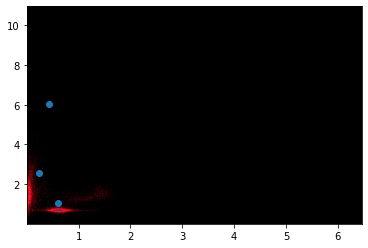

In [20]:
classes = ["solar_wind", "magnetosheath", "magnetopause"]

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,random_state=0)
x_train = np.vstack((np.log(1+r_n),np.log(1+r_b))).T
print(x_train.shape)
kmeans=kmeans.fit(x_train)
print(kmeans.cluster_centers_)

plt.figure()
#plt.hist2d(np.log(1+r_n), np.log(1+r_b), bins=1000, range=domain_,cmap=cmap)
plt.hist2d(np.log(1+r_n), np.log(1+r_b), bins=1000, range=None,cmap=cmap)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])

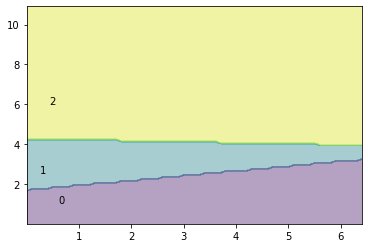

In [21]:
def plot_decision_region(x, y, clf, ax):
    x_min, x_max = x[:,0].min(), x[:,0].max()
    y_min, y_max = x[:,1].min(), x[:,1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                        np.arange(y_min,y_max,.1))
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    
    ax.contourf(xx, yy, z, alpha=.4)
    if y is not None:
        yx, yy = y
        ax.scatter(yx[:,0], yx[:,1], c=yy, s=20, edgecolor="k")
    
    if hasattr(clf, "cluster_centers_" ):
        c=0
        for cc in clf.cluster_centers_:
            ax.text(cc[0],cc[1],str(c))
            c+=1
    return ax

fig=plt.figure()
plot_decision_region(x_train,None,kmeans,fig.gca())
plt.show()

In [22]:
# clustering
def domain_contains(x, domain):
    if domain is None:
        return True
    if np.any(np.isnan(x)):
        return False
    for i in np.arange(x.shape[0]):
        if x[i] < domain[i][0] or x[i]>domain[i][1]:
            return False
    return True

def normalize(x):
    r= (x - np.mean(x)) / np.std(x)
    return r

r_b_log, r_n_log = np.log(1+r_b), np.log(1+r_n)
r_b_mean, r_b_std = np.mean(r_b_log), np.std(r_b_log)
r_n_mean, r_n_std = np.mean(r_n_log), np.std(r_n_log)

r_b_norm = normalize(r_b_log)
r_n_norm = normalize(r_n_log)

# domain correction
#domain[0] = (domain[0]-r_n_mean) / r_n_std
#domain[1] = (domain[1]-r_b_mean) / r_b_std
domain = None

#x_train = np.vstack((r_n,r_b)).T
x_train = np.vstack((r_n_norm, r_b_norm)).T
index = np.apply_along_axis(lambda x: domain_contains(x,domain), 1, x_train)
x_train = x_train[index]
print(f"x_train.shape : {x_train.shape}")

x_train.shape : (1084227, 2)


n_clusters : 3
n_clusters : 6
n_clusters : 9


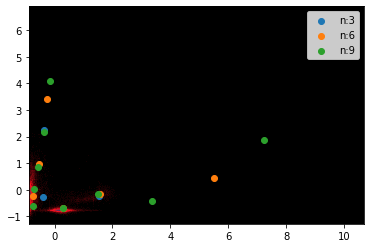

In [23]:
plt.figure()
#plt.hist2d(np.log(1+x_train[:,0]), np.log(1+x_train[:,1]), bins=1000, range=None,cmap=cmap)
plt.hist2d(x_train[:,0], x_train[:,1], bins=1000, range=None,cmap=cmap)

for n_c in [3,6,9]:
    print(f"n_clusters : {n_c}")
    kmeans = KMeans(n_clusters=n_c,random_state=0).fit(x_train)
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label=f"n:{n_c}")

plt.legend()
plt.show()

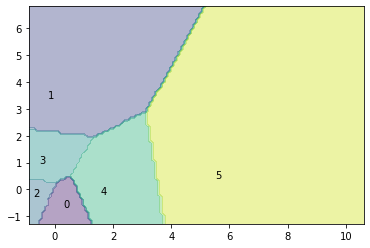

In [24]:
# decision regions for KMeans(6)
#kmeans = KMeans(n_clusters=6,random_state=0).fit(np.log(1+x_train))
kmeans = KMeans(n_clusters=6,random_state=0).fit(x_train)
fig=plt.figure()
plot_decision_region(x_train,None,kmeans,fig.gca())
plt.show()

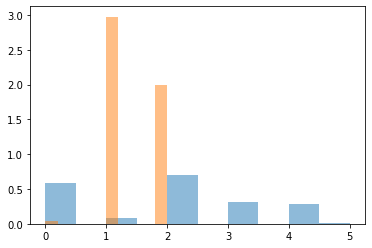

In [25]:
class_map = {0: [5], 1: [0,3,4], 2: [1,2]}
#x_train_log = np.log(1+x_train)
def map_classes(y, m):
    yr = y.copy()
    for k in m:
        for ic in m[k]:
            yr = np.where(y==ic, k, yr)
    return yr

y_train_ = kmeans.predict(x_train)
y_train = map_classes(y_train_, class_map)
plt.figure()
plt.hist(y_train_,alpha=.5,density=True)
plt.hist(y_train, alpha=.5,density=True)
plt.show()

x_train.shape : (1084227, 2)
Estimated number of clusters: 4
Estimated number of noise points: 61
(6650, 2)
n_clusters : 4


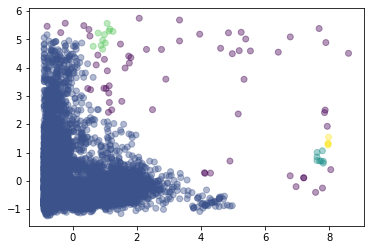

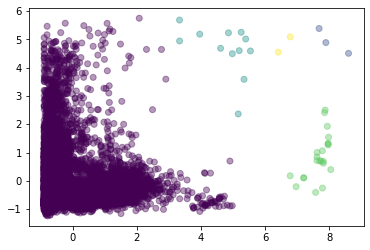

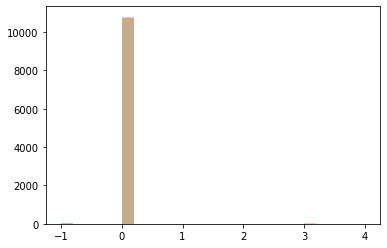

In [26]:
# DBSCAN
print(f"x_train.shape : {x_train.shape}")
from sklearn.cluster import DBSCAN
r_indx = np.arange(0,x_train.shape[0],100)
r_indx = np.random.choice(range(x_train.shape[0]), size=r_indx.shape[0])
x_train_rand = x_train[r_indx]
db = DBSCAN(eps=.3, leaf_size=8,).fit(x_train_rand)

# Spectral
from sklearn.cluster import SpectralClustering
spct = SpectralClustering(n_clusters=5)
spct_z = spct.fit_predict(x_train_rand)


labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

fig=plt.figure()
ax = fig.gca()
#plot_decision_region(x_train,None,clst,fig.gca())
#plt.show()

x_min, x_max = x_train_rand[:,0].min(), x_train_rand[:,0].max()
y_min, y_max = x_train_rand[:,1].min(), x_train_rand[:,1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                        np.arange(y_min,y_max,.1))
z = labels #clf.predict(np.c_[xx.ravel(), yy.ravel()])
print(np.c_[xx.ravel(), yy.ravel()].shape)

#db = DBSCAN(leaf_size=8,).fit(np.c_[xx.ravel(), yy.ravel()])
z = db.labels_
n_clusters_ = len(set(z)) - (1 if -1 in z else 0)
print(f"n_clusters : {n_clusters_}")
#z = z.reshape(xx.shape)
#z = z.reshape(xx.shape)
    
ax.scatter(x_train_rand[:,0], x_train_rand[:,1], c=z, alpha=.4)

plt.figure()
plt.gca().scatter(x_train_rand[:,0], x_train_rand[:,1], c=spct_z, alpha=.4)
#zz = spct.predict(np.c_[xx.ravel(), yy.ravel()])
#zz = zz.reshape(xx.shape)
#plt.gca().contourf(xx,yy, zz)

plt.figure()
plt.hist(z.flatten(), bins=20, alpha=.4)
plt.hist(spct_z.flatten(), bins=20, alpha=.4)
plt.show()



DBSCAN
	number of clusters: 4
	number of noise points: 39
DBSCAN
	number of clusters: 8
	number of noise points: 0


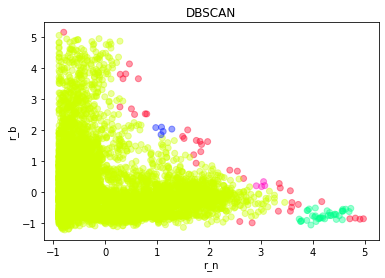

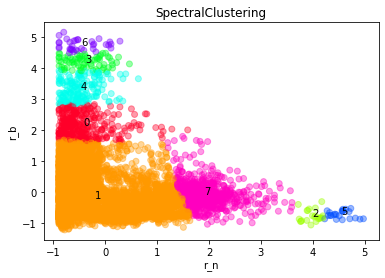

In [27]:
np.random.seed(1)
# blob
blob_indx = (z == 0)
#plt.scatter(x_train_rand[blob_indx,0], x_train_rand[blob_indx,1])
blob_x_train = x_train_rand[blob_indx]

db = DBSCAN(eps=.2, leaf_size=30,).fit(blob_x_train)
db_z = db.labels_
spct_z = SpectralClustering().fit_predict(blob_x_train)


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)
print("DBSCAN")
print("\tnumber of clusters: %d" % n_clusters_)
print("\tnumber of noise points: %d" % n_noise_)

# Number of clusters in labels, SpectralClustering
n_clusters_ = len(set(spct_z)) - (1 if -1 in spct_z else 0)
n_noise_ = list(spct_z).count(-1)
print("DBSCAN")
print("\tnumber of clusters: %d" % n_clusters_)
print("\tnumber of noise points: %d" % n_noise_)

cmap = "gist_rainbow" #magma

plt.figure()
plt.title("DBSCAN")
plt.scatter(blob_x_train[:,0], blob_x_train[:,1], c=db_z,cmap=cmap, alpha=.4)
plt.xlabel("r_n")
plt.ylabel("r_b")

plt.figure()
plt.title("SpectralClustering")
plt.scatter(blob_x_train[:,0], blob_x_train[:,1], c=spct_z,cmap=cmap, alpha=.4)
for cl in set(spct_z):
    [xx,yy] = np.mean(blob_x_train[spct_z==cl],axis=0)
    plt.text(xx,yy,str(cl))
plt.xlabel("r_n")
plt.ylabel("r_b")
plt.show()

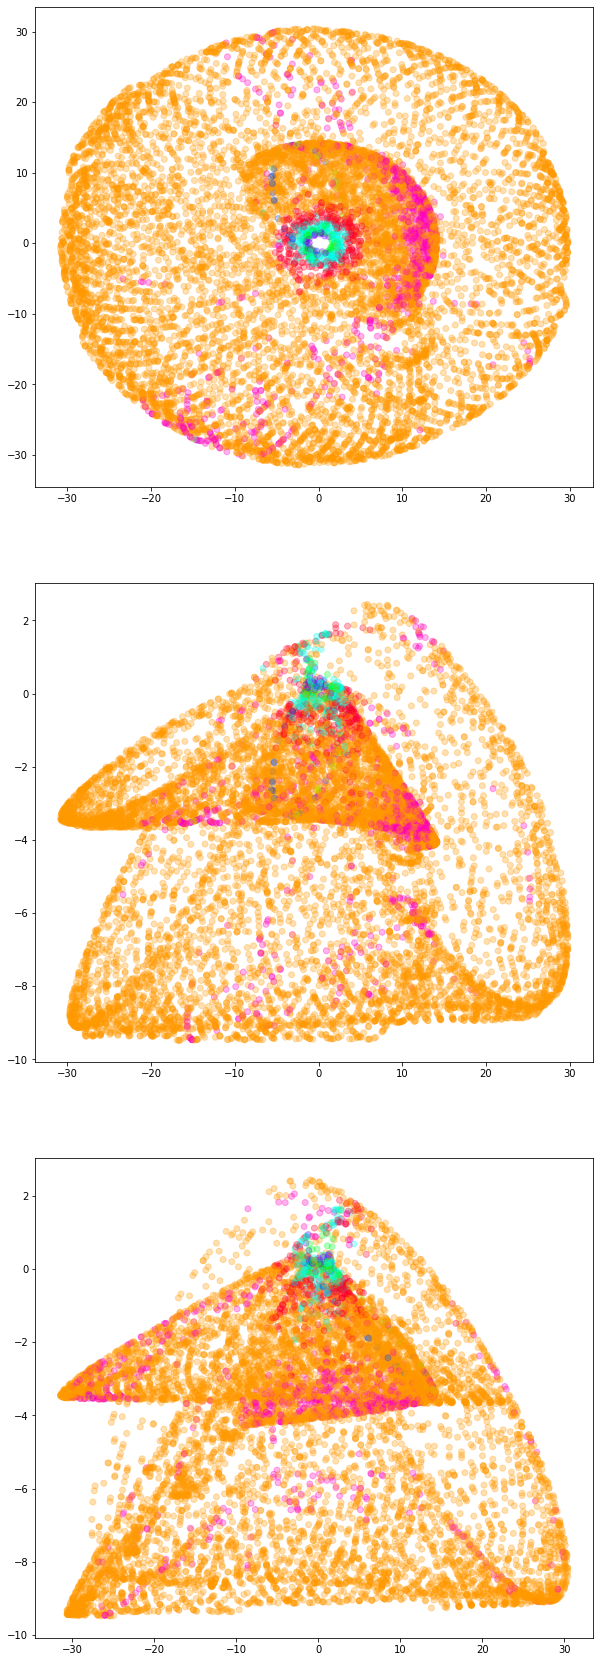

In [28]:
dims = np.array([[0,1],[0,2],[1,2]])
tha_xyz = interpolated_data["thb_xyz"]
tha_xyz_blob = tha_xyz[r_indx]
tha_xyz_blob=tha_xyz_blob[blob_indx]
classes = set(spct_z)

fig,axes = plt.subplots(3,1,figsize=(10,30))
for i in range(3):
    [u,v] = dims[i]
    axes[i].scatter(tha_xyz_blob[:,u], tha_xyz_blob[:,v], c=spct_z,cmap=cmap, alpha=.3)

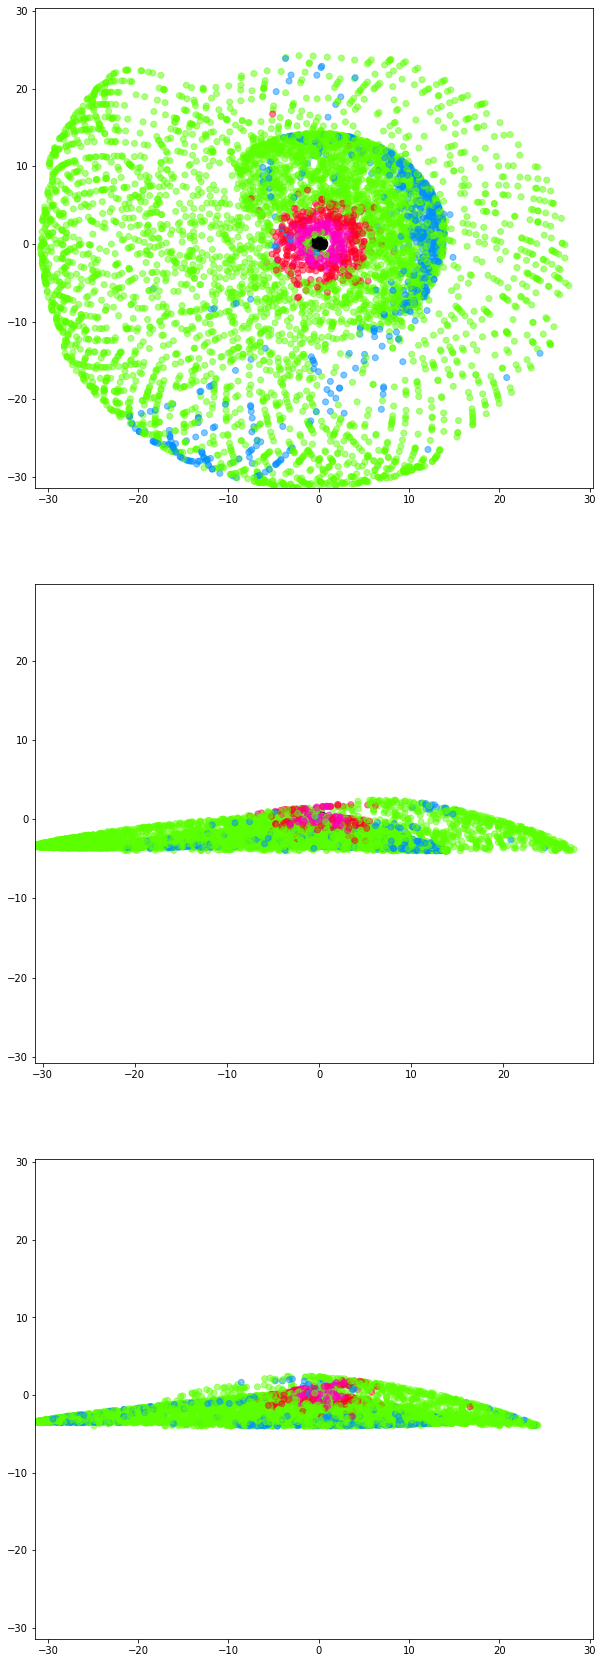

In [29]:
# map classes : 0 is SolarWind, 1: magnetosphere, 2: magnetosheat, 3: inner
class_map = {0:[0], 1:[1,6,2],2:[7,5],3:[3,4]}
y_spct = map_classes(spct_z, class_map)

fig,axes = plt.subplots(3,1,figsize=(10,30))
for i in range(3):
    [u,v] = dims[i]
    earth_circle = plt.Circle([0,0],1,color="black")
    axes[i].add_patch(earth_circle)
    # axis limits
    xmin,xmax=tha_xyz_blob[:,u].min(),tha_xyz_blob[:,u].max()
    ymin,ymax=tha_xyz_blob[:,v].min(),tha_xyz_blob[:,v].max()
    xmin = ymin = min(xmin,ymin)
    xmax = ymax = max(xmax,ymax)
    axes[i].set_xlim(xmin,xmax)
    axes[i].set_ylim(ymin,ymax)
    indx = (np.abs(tha_xyz_blob[:,2]) < 4.)
    axes[i].scatter(tha_xyz_blob[indx,u], tha_xyz_blob[indx,v], c=y_spct[indx],cmap=cmap, alpha=.5)
plt.show()

<AxesSubplot:>

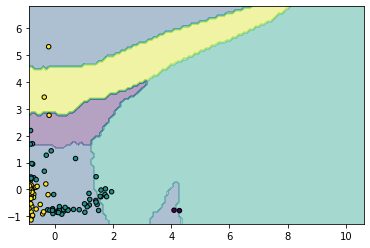

In [30]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
#knn.fit(x_train, y_train)
knn.fit(x_train_rand[blob_indx], y_spct)

I = np.random.choice(np.arange(y_train.shape[0]), size=100)
Y = (x_train[I], y_train[I])
f = plt.figure()
plot_decision_region(x_train, Y, knn, f.gca())

<AxesSubplot:>

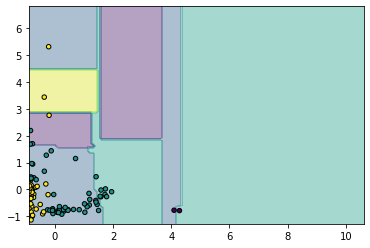

In [31]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
#tree.fit(x_train, y_train)
tree.fit(x_train_rand[blob_indx], y_spct)

f = plt.figure()
plot_decision_region(x_train, Y, tree, f.gca())

<AxesSubplot:>

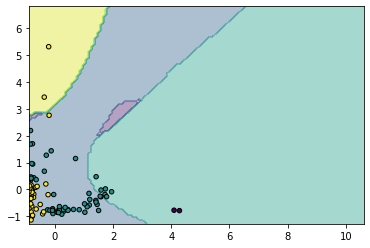

In [32]:
from sklearn.svm import SVC

svc_poly = SVC(kernel="poly")
#svc_poly.fit(x_train, y_train)
svc_poly.fit(x_train_rand[blob_indx], y_spct)

f = plt.figure()
plot_decision_region(x_train, Y, svc_poly, f.gca())

<AxesSubplot:>

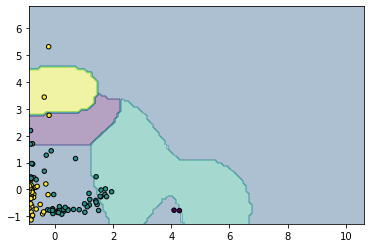

In [33]:
svc = SVC()
#svc.fit(x_train_log, y_train)
svc.fit(x_train_rand[blob_indx], y_spct)

f = plt.figure()
plot_decision_region(x_train, Y, svc, f.gca())

In [34]:
def plot_slices(clf, target_dir, dt=1.):
    if os.path.exists(target_dir):
        os.system(f"rm -r {target_dir}/*")
    else:
        os.system(f"mkdir -p {target_dir}")
    
    offsets = -np.arange(0,4+dt,dt) #[0, -1, -2]
    for offset in offsets:
        norms = [2,1,0]
        fig, axes = plt.subplots(1,1,figsize=(5,5))
        axes.set_title(f"offset : {offset}")
        for i in range(1):
            [u,v]=dims[i]
            index_slice = (np.abs(tha_xyz[:,norms[i]] - offset) < dt/2)
            x_min,x_max = tha_xyz[:,u].min(),tha_xyz[:,u].max()
            y_min,y_max = tha_xyz[:,v].min(),tha_xyz[:,v].max()
            if not index_slice.size:
                continue
            axes.set_xlim(x_min,x_max)
            axes.set_ylim(y_min,y_max)
            axes.scatter(tha_xyz[index_slice,u],tha_xyz[index_slice,v],
                    c=clf.predict(x_train[index_slice]),
                    marker=".",alpha=.1,cmap=cmap)
        #plt.tight_layout()
        filename = os.path.join(target_dir, f"offset_{offset}.png")
        plt.savefig(filename)
        plt.close("all")

target_dir = "slices"

clfs = [knn, tree, svc, svc_poly]
for clf, name in zip(clfs, ["knn","tree","svc","svc_poly"]):
    plot_slices(clf, os.path.join(target_dir, name))



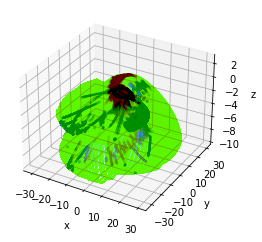

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
#idx=(np.abs(tha_xyz[:,2])<.5)
ax.scatter(tha_xyz[:,0], tha_xyz[:,1], tha_xyz[:,2], 
           c=knn.predict(x_train[:]), 
           marker=".",
           alpha=.002,
           cmap="gist_rainbow")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [36]:
# Themis A Ephemeris
tha_gse = parameter_data["thb_xyz"]#=spz.get_data("amda/tha_xyz", start_d, stop_d)

0.008946466007579593 97
gist_rainbow


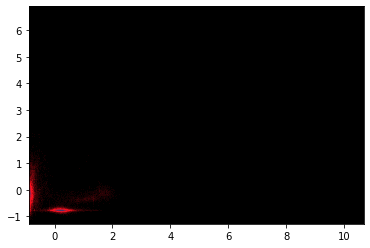

In [37]:
tha_gse_interp = interp1d(tha_gse.time, 
                          tha_gse.data, 
                          axis=0, bounds_error=False)
#t=pd.date_range(start_t, stop_t,freq="1H").astype(np.int64)/1e9
tha_interp_data = tha_gse_interp(t)

tha_gse_norm = np.linalg.norm(tha_interp_data, axis=1)
indx = (tha_gse_norm <= 1.1)
print(100. * np.sum(indx) / t.shape[0], np.sum(indx))

plt.figure()
a,b = np.log(1+r_n), np.log(1+r_b)
#a,b = r_n, r_b
a,b = normalize(a), normalize(b)
#plt.hist2d(np.log(1+r_n), np.log(1+r_b), bins=100, range=domain_,cmap=cmap)
print(cmap)
plt.hist2d(a, b, bins=1000, range=None,cmap="gist_stern")
#plt.scatter(np.log(1+r_n[indx]),np.log(1+r_b[indx]), c="y")
plt.show()

In [38]:
raise KeyboardInterrupt
#%matplotlib notebook
import matplotlib.animation as animation

tha_gse_interp = interp1d(tha_gse.time, 
                          tha_gse.data, 
                          axis=0, bounds_error=False)
#t=pd.date_range(start_t, stop_t,freq="1H").astype(np.int64)/1e9
tha_interp_data = tha_gse_interp(t)

# interpolate r_n and r_b at the same time
#r_b_new = np.linalg.norm(interpolations["tha_bs"](t), axis=1) / \
#      np.linalg.norm(interpolations["imf"](t), axis=1)

#r_n_new = (interpolations["tha_n_i"](t) / interpolations["sw_n"](t)).flatten()

duration =1*60 # seconds
fps = 60
n = t.shape[0]
frames = duration * fps
step = int(n / frames)
interval = int(duration*1000 / frames)

indx = np.arange(0, n, step).astype(int)
print(indx)

print(f"duration : {duration}")
print(f"fps      : {fps}")
print(f"frames   : {frames}")
print(f"interval : {interval}")
print(f"step     : {step}")


fig, axes = plt.subplots(3,1,figsize=(4,10))
alpha = .3
lines = [None for _ in np.arange(15)]
dims = [[0,1],[0,2],[1,2]]
for i in [0,1,2]:
    ii = i * 5
    lines[ii], = axes[i].plot([],[])
    lines[ii+1], = axes[i].plot([],[],"+", c="r",alpha=alpha)
    lines[ii+2], = axes[i].plot([],[],"+", c="g",alpha=alpha)
    lines[ii+3], = axes[i].plot([],[],"+", c="b",alpha=alpha)
    lines[ii+4], = axes[i].plot([],[],"+", c="m",alpha=alpha)
    u,v = dims[i]
    axes[i].set_xlim(tha_interp_data[:,u].min(),tha_interp_data[:,u].max())
    axes[i].set_ylim(tha_interp_data[:,v].min(),tha_interp_data[:,v].max())
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")

#axes[3].hist2d(x_train_log[:,0], x_train_log[:,1], bins=1000, range=None,cmap=cmap)
#pos_line, = axes[3].plot([],[],"o",c="y")
#lines.append(pos_line)
#line, = ax.plot([],[])
#line2, = ax.plot([],[],"+", c="r",alpha=alpha)
#line3, = ax.plot([],[],"+", c="g",alpha=alpha)
#line4, = ax.plot([],[],"+", c="b",alpha=alpha)

print(tha_interp_data[:,0].min(),tha_interp_data[:,0].max())
print(tha_interp_data[:,1].min(),tha_interp_data[:,1].max())
#raise KeyboardInterrupt

#ax.set_xlim(tha_interp_data[:,0].min(),tha_interp_data[:,0].max())
#ax.set_ylim(tha_interp_data[:,1].min(),tha_interp_data[:,1].max())

frontier_data={0:[],1:[],2:[],3:[]}

svm_blob=[]

N=24

#clf = svc_poly
#clf = tree
#clf = svc
clf = knn

axes[0].set_title(clf.__class__.__name__)
R= None

def animate(i):
    global R, dims,frontier_data,clf
    
    j = indx[i]
    #print(j)
    #print(f"j:{j}")
    if j>N:
        x, y = tha_interp_data[j-N:j,0], tha_interp_data[j-N:j,1]
        X = tha_interp_data[j-N:j,:]
    else:
        x, y = tha_interp_data[:j,0], tha_interp_data[:j,1]
        X = tha_interp_data[:j,:]
    #print(r_b_new[i], r_n_new[i])
    xnew = np.array([[r_n_norm[j], r_b_norm[j]]])
    #print(xnew)
    
    if not np.any(np.isnan(xnew)):
        #xnew = np.log(1+xnew)
        p=clf.predict(xnew)[0]
        
        if R is None:
            R = int(p)
            if not R in frontier_data:
                frontier_data[R] = []
            
            #frontier_data[R].append(tha_interp_data[j,:])
                
        else:
            if int(p)!=R:
                nR=int(p)
                if not nR in frontier_data:
                    frontier_data[nR] = []
                #frontier_data[nR].append(tha_interp_data[j,:])
                #frontier_data[R].append(tha_interp_data[j-1,:])
                R = int(p)
        frontier_data[R].append(tha_interp_data[j,:])
        #frontier_data[R][1].append(tha_interp_data[j,1])
        
        for l in [0,1,2]:
            ii=l*5
            #print(l, dims[l], X)
            [u,v] = dims[l]
            if X.size:
                lines[ii].set_data(X[:,u],X[:,v])
            
            if len(frontier_data[0]):
                tt = np.array(frontier_data[0])
                uu,vv = dims[0]
                lines[ii+1].set_data(tt[:,u],tt[:,v])
            if len(frontier_data[1]):
                tt = np.array(frontier_data[1])
                uu,vv = dims[1]
                lines[ii+2].set_data(tt[:,u],tt[:,v])
            if len(frontier_data[2]):
                tt = np.array(frontier_data[2])
                uu,vv = dims[2]
                lines[ii+3].set_data(tt[:,u],tt[:,v])
            if len(frontier_data[3]):
                tt = np.array(frontier_data[3])
                lines[ii+4].set_data(tt[:,u],tt[:,v])
        if np.linalg.norm(X)<4:
            svm_blob.append(xnew)
        #line2.set_data(frontier_data[0][0],frontier_data[0][1])
        #line3.set_data(frontier_data[1][0],frontier_data[1][1])
        #line4.set_data(frontier_data[2][0],frontier_data[2][1])
        #lines[12].set_data([xnew[0,0]],[xnew[0,1]])
        
    
    #line.set_data(X[u],X[v])
    return tuple(lines)
    return line,line2,line3,line4

#for i in np.arange(1000):
#    animate(i)
ani = animation.FuncAnimation(fig, animate, frames=frames, blit=True, 
                             interval=interval,
                          repeat=False)

plt.show()



KeyboardInterrupt: 

In [ ]:
predictions = []
for clf in clfs:
    predictions.append(clf.predict(x_train))
    if len(predictions)>1:
        for p in predictions:
            print(clf.__class__.__name__, np.sum(p != predictions[-1]))

m = len(clfs)
fig, axes = plt.subplots(m,m,sharex=True,sharey=True)
for i in range(m):
    for j in range(m):
        if i!=j:
            axes[i,j].hist(predictions[i][predictions[i] != predictions[j]], alpha=.5, density=True)
            axes[i,j].hist(predictions[j][predictions[i] != predictions[j]], alpha=.5, density=True)
#plt.tight_layout()
plt.show()

In [ ]:
# interpolating on slices
indx = (np.abs(tha_xyz[:,2]) < .4)
print("npoints ", np.sum(indx))
# position data
pos_data = tha_xyz[indx]
# predictions
pred_data = predictions[0][indx]
import matplotlib.tri as tri

fig = plt.figure()
plt.tricontour(pos_data[:,0], pos_data[:,1], pred_data, 15)
plt.show()

In [ ]:
from scipy.interpolate import interp2d

print(pos_data.shape[0])
rindx = np.random.choice(range(pos_data.shape[0]), size=2000)
rindx = np.arange(0, pos_data.shape[0], 5)

ii = interp2d(pos_data[rindx,0], pos_data[rindx,1], pred_data[rindx],
             kind="linear")
print(ii)

In [ ]:
import matplotlib as mpl
mcl,Mcl = pred_data.min(), pred_data.max()
xmin,xmax=pos_data[:,0].min(),pos_data[:,1].max()
ymin,ymax=pos_data[:,1].min(),pos_data[:,1].max()
xx = np.linspace(xmin, xmax, 1000)
yy = np.linspace(ymin, ymax, 1000)
#xx, yy = np.meshgrid(xx, yy)
plt.figure(figsize=(10,10))
ttt={0:"r",1:"g",2:"b",3:"m"}
#cmap = (mpl.colors.ListedColormap(['r', 'g', 'b', 'm']))
#        .with_extremes(over='0.25', under='0.75'))
#bounds = [0, 1, 2, 3, 4]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmap = mpl.colors.ListedColormap(['r','g','b','m'])
cs = plt.gca().contourf(xx, yy, 
                        np.clip(ii(xx,yy), mcl, Mcl).astype(int),
                       cmap=cmap)
#fig.colorbar(cs, ax=plt.gca(), shrink=0.9)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap),
    ax=plt.gca(),
    #boundaries=[0] + bounds + [13],  # Adding values for extensions.
    #extend='both',
    #ticks=bounds,
    spacing='proportional',
    orientation='vertical',
    #label='Discrete intervals, some other units',
)
plt.show()

In [ ]:
# interpolate r_n and r_b 
R=5.
xx, yy = np.linspace(-R,R,1000), np.linspace(-R,R,1000)
zz_r_n = interp2d(pos_data[rindx,0], pos_data[rindx,1], r_n_norm[rindx],
             kind="cubic")
zz_r_b = interp2d(pos_data[rindx,0], pos_data[rindx,1], r_b_norm[rindx],
             kind="cubic")

#temp_z = np.vstack((r_n_norm[rindx],r_b_norm[rindx])).T
#print (f"temp_z.shape : {temp_z.shape}")

#zz_r = interp2d(pos_data[rindx,0], pos_data[rindx,1],temp_z)

fig, axes = plt.subplots(2,1,figsize=(10,20))
#axes[0].set_xlim(0,10)
#axes[0].set_ylim(0,10)
cs0 = axes[0].contourf(xx,yy,zz_r_n(xx,yy),cmap="gist_rainbow")
#axes[1].set_xlim(0,10)
#axes[1].set_ylim(0,10)
cs1 = axes[1].contourf(xx,yy,zz_r_b(xx,yy),cmap="gist_rainbow")
fig.colorbar(cs0, ax=axes[0])
fig.colorbar(cs1, ax=axes[1])

plt.show()

In [ ]:
tsh = zz_r_n(xx,yy).shape
zz_x = np.c_[zz_r_n(xx,yy).ravel(),zz_r_b(xx,yy).ravel()]

fig, axes =plt.subplots(m,1,figsize=(10,m*10))
for i in range(m):
    name = clfs[i].__class__.__name__
    print(i, name)
    pp = clfs[i].predict(zz_x).reshape(tsh)
    axes[i].set_title(name)
    #cmap = mpl.colors.ListedColormap(['r','g','b','m'])
    cs=axes[i].contourf(xx,yy,pp,cmap=cmap)
    earth_circle = plt.Circle([0,0],1,color="black")
    axes[i].add_patch(earth_circle)
    fig.colorbar(cs,ax=axes[i])
plt.show()

In [ ]:
f=plt.figure()
plt.hist2d(x_train_log[:,0], x_train_log[:,1], bins=1000, range=None,cmap=cmap)
x_svm_blob = np.array(svm_blob)
print(x_svm_blob.shape)
plt.scatter(x_svm_blob[:,0], x_svm_blob[:,1],".",c="y")
plt.show()

In [ ]:
from scipy import constants as cst

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(x / r)
    phi = np.arctan2(y, z)
    phi[z==0]=np.sign(y[z==0])*np.pi/2
    return r, theta, phi

def spherical_to_cartesian(r, theta, phi):
    x = r * np.cos(theta)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.sin(theta) * np.cos(phi)
    return x, y, z

def choice_coordinate_system(R, theta, phi, **kwargs):
    coord_sys = kwargs.get('coord_sys','cartesian')
    if coord_sys == 'cartesian':
        return spherical_to_cartesian(R, theta, phi)
    elif coord_sys == 'spherical':
        return R, theta, phi
    else:
        print('Error : coord_sys parameter must be set to "cartesian" or "spherical" ')

def bs_Jerab2005(theta, phi, **kwargs):
    '''
    Jerab 2005 Bow shock model. Give positions of the box shock in plans (XY) with Z=0 and (XZ) with Y=0 as a function of the upstream solar wind.
    function's arguments :
        - Np : Proton density of the upstream conditions
        - V  : Speed of the solar wind
        - B  : Intensity of interplanetary magnetic field
        - gamma : Polytropic index ( default gamma=2.15)
        --> mean parameters :  Np=7.35, V=425.5,  B=5.49
     return : DataFrame (Pandas) with the position (X,Y,Z) in Re of the bow shock to plot (XY) and (XZ) plans.
    '''

    def make_Rav(theta, phi):
        a11 = 0.45
        a22 = 1
        a33 = 0.8
        a12 = 0.18
        a14 = 46.6
        a24 = -2.2
        a34 = -0.6
        a44 = -618

        x = np.cos(theta)
        y = np.sin(theta) * np.sin(phi)
        z = np.sin(theta) * np.cos(phi)

        a = a11 * x ** 2 +  a22 * y ** 2 + a33 * z ** 2 + a12 * x * y
        b = a14 * x + a24 * y + a34 * z
        c = a44

        delta = b ** 2 - 4 * a * c

        R = (-b + np.sqrt(delta)) / (2 * a)
        return R

    Np = kwargs.get('Np', 6.025)
    V = kwargs.get('V', 427.496)
    B = kwargs.get('B', 5.554)
    gamma = kwargs.get('gamma', 5./3)
    Ma = V * 1e3 * np.sqrt(Np * 1e6 * cst.m_p * cst.mu_0) / (B * 1e-9)

    C = 91.55
    D = 0.937 * (0.846 + 0.042 * B)
    R0 = make_Rav(0, 0)

    Rav = make_Rav(theta, phi)
    K = ((gamma - 1) * Ma ** 2 + 2) / ((gamma + 1) * (Ma ** 2 - 1))
    r = (Rav / R0) * (C / (Np * V ** 2) ** (1 / 6)) * (1 + D * K)

    return choice_coordinate_system(r, theta, phi, **kwargs)        

def mp_shue1997(theta, phi, **kwargs):
    Pd = kwargs.get("Pd", 1.82) #2.056)
    Bz = kwargs.get("Bz", -0.001)

    if isinstance(Bz, float) | isinstance(Bz, int):
        if Bz >= 0:
            r0 = (11.4 + 0.13 * Bz) * Pd ** (-1 / 6.6)
        else:
            r0 = (11.4 + 0.14 * Bz) * Pd ** (-1 / 6.6)
    else:
        if isinstance(Pd, float) | isinstance(Pd, int):
            Pd = np.ones_like(Bz) * Pd
        r0 = (11.4 + 0.13 * Bz) * Pd ** (-1 / 6.6)
        r0[Bz < 0] = (11.4 + 0.14 * Bz[Bz < 0]) * Pd[Bz < 0] ** (-1 / 6.6)
    a = (0.58 - 0.010 * Bz) * (1 + 0.010 * Pd)
    r = r0 * (2. / (1 + np.cos(theta))) ** a
    return choice_coordinate_system(r, theta, phi, **kwargs)

In [ ]:
phis = np.linspace(0, np.pi/4 , 1)
plt.figure()
earth = plt.Circle((0,0),1,color="black")
plt.gca().add_patch(earth)

for ph in phis:
    theta, phi = np.linspace(0, 2*np.pi, 100), ph*np.ones(100)
    x,y,z = mp_shue1997(theta, phi)

    print(x.shape, y.shape, z.shape)
    plt.plot(x,z)
    x,y,z = bs_Jerab2005(theta, phi)
    plt.plot(x,z,"--")

plt.xlim([-30,30])
plt.ylim([-30,30])
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
indx = (np.abs(tha_xyz_blob[:,2]) < 3)
tha_x = tha_xyz_blob[indx]

xmin,xmax = tha_x[:,0].min(), tha_x[:,0].max()
ymin,ymax = tha_x[:,1].min(), tha_x[:,1].max()

x,y,z = mp_shue1997(theta, np.zeros(100))
plt.plot(x,z,"black")
x,y,z = bs_Jerab2005(theta, phi)
plt.plot(x,z,"--",c="black")
plt.scatter(tha_x[:,0], tha_x[:,1], c=spct_z[indx],cmap=cmap, alpha=.3)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

In [ ]:
def get_position_class(x):
    # spherical coordinates
    r,theta,phi = cartesian_to_spherical(x[:,0],x[:,1],x[:,2])
    # bow shock
    bs_x, bs_y, bs_z = bs_Jerab2005(theta, phi)
    bs_dist = np.linalg.norm(np.vstack((bs_x,bs_y,bs_z)).T, axis=1)
    # magnetopause
    mp_x, mp_y, mp_z = mp_shue1997(theta, phi)
    mp_dist = np.linalg.norm(np.vstack((mp_x,mp_y,mp_z)).T, axis=1)
    
    # x norm
    x_dist = np.linalg.norm(x, axis=1)
    
    ans = np.zeros(x.shape[0]).astype(int)
    ans[x_dist <= mp_dist] = 1 # magnetoshere
    ans[(mp_dist < x_dist) & (x_dist <= bs_dist)] = 2 # magnetosheath
    ans[bs_dist < x_dist] = 0 # solar wind
    
    return ans


In [ ]:
# real labels
real_labels = get_position_class(tha_xyz)

fig = plt.figure()
#indx = (np.abs(tha_xyz_blob[:,2]) < 3)
#tha_x = tha_xyz_blob[indx]

xmin,xmax = tha_xyz[:,0].min(), tha_xyz[:,0].max()
ymin,ymax = tha_xyz[:,1].min(), tha_xyz[:,1].max()

x,y,z = mp_shue1997(theta, np.zeros(100))
plt.plot(x,z,"black")
x,y,z = bs_Jerab2005(theta, np.zeros(100))
plt.plot(x,z,"--",c="black")
plt.scatter(tha_xyz[:,0], tha_xyz[:,1], c=real_labels,cmap=cmap, alpha=.1)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.show()

In [ ]:
x__ = np.vstack((r_n_norm,r_b_norm)).T
pred_labels = knn.predict(x__)
print(np.sum(pred_labels == 0))
print(np.sum(pred_labels == 1))
print(np.sum(pred_labels == 2))
print(np.sum(pred_labels == 3))
print(pred_labels.shape[0])
print()
pred_labels = np.where(pred_labels==3, 1, pred_labels)

# correct sw
sw_indx = (pred_labels==0)
eps = .1
sw_one = (r_b <= 1. + eps)
print(sw_indx.shape, sw_one.shape)
print("aa  ",np.sum(sw_one), np.sum(sw_indx), np.sum(sw_indx & sw_one))
#pred_labels[sw_indx & sw_one] = 1
print(np.sum(pred_labels == 0))
print(np.sum(pred_labels == 1))
print(np.sum(pred_labels == 2))
print(np.sum(pred_labels == 3))

In [ ]:
from sklearn.metrics import *
print(f"Accuracy  : {accuracy_score(real_labels, pred_labels)}")
print(f"Precision : {precision_score(real_labels, pred_labels,average='macro')}")
print(f"Recall    : {recall_score(real_labels, pred_labels,average='macro')}")
print(f"F1-score  : {f1_score(real_labels, pred_labels,average='macro')}")
print(np.sum(real_labels != pred_labels))
print(np.sum(pred_labels == 2))
ConfusionMatrixDisplay.from_predictions(real_labels, pred_labels,normalize="all")

In [ ]:
# Spectral clustering
N = r_b.shape[0]

def cluster_recursive(x, xyz, n_clusters=5):
    if n_clusters <= 0:
        return []
    if x.shape[0] < n_clusters:
        return []
    kmeans = KMeans(n_clusters=n_clusters)
    pred = kmeans.fit_predict(x)
    classes = set(pred)
    pure_classes = []
    for cl in classes:
        pos_class = get_position_class(xyz[pred==cl])
        unq = np.unique(pos_class)
        if unq.size==1:
            nshape = (np.sum(pred==cl), 2)
            lshape = np.sum(pred==cl)
            pure_classes.append((x[pred==cl].reshape(nshape), pos_class.reshape(lshape)))
        else:
            # more then one class in this cluster
            p = cluster_recursive(x[pred==cl], xyz[pred==cl], n_clusters=n_clusters-1)
            if len(p)==0:
                nshape = (np.sum(pred==cl), 2)
                lshape = np.sum(pred==cl)
                pure_classes.append((x[pred==cl].reshape(nshape), pos_class.reshape(lshape)))
            else:
                for pp in p:
                    pure_classes.append(pp)

    c0 = pure_classes.pop(0)
    xx,yy = c0[0],c0[1]
    while len(pure_classes):
        pp = pure_classes.pop(0)
        xx = np.vstack((xx,pp[0]))
        yy = np.hstack((yy,pp[1]))
        
    return [(xx,yy)]
            

indx = np.random.choice(range(N), 5000)
indx = np.arange(0, N, 100)
X = np.vstack((r_n,r_b)).T
[(a,b)]=cluster_recursive(X[indx], tha_xyz[indx])

fig = plt.figure()
plt.scatter(X[indx,0], X[indx,1], c=b)
plt.xlim([0,30])
plt.ylim([0,30])

fig=plt.figure()
cs=plt.scatter(np.log(1+X[indx,0]), np.log(1+X[indx,1]), c=b)
plt.xlim([0,6])
plt.ylim([0,6])
plt.colorbar(cs)
plt.show()

In [ ]:
real_labels = get_position_class(tha_xyz)

N = r_b.shape[0]
X = np.vstack((r_n,r_b)).T

knn2 = KNeighborsClassifier()
indx = np.arange(0, N, 1000)
knn2.fit(X[indx], real_labels[indx])
fig = plt.figure()
plot_decision_region(X[indx], None, knn2, f.gca())
plt.show()